## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

REPO_ROOT = "/home/leon/models/NeuroTorch"
pal = sns.color_palette("tab10")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Helpers



In [1]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

In [1]:
def get_df_X(rates, X_list, X_str='Ie'):
    n_times, n_trials, n_phi, n_X, n_neurons = rates.shape

    time_ind, trials_ind, phi_ind, X_ind, neurons_ind = np.meshgrid(
        np.arange(n_times),
        np.arange(n_trials),
        np.arange(n_phi),
        np.arange(n_X),
        np.arange(n_neurons),
        indexing='ij'
    )

    # Construct DataFrame
    df = pd.DataFrame({
        'time': time_ind.flatten(),
        'trial': trials_ind.flatten(),
        'phi': phi_ind.flatten(),
        X_str : X_ind.flatten() * np.round((X_list[-1] - X_list[0]) / (X_list.shape[0] -1), 5) + X_list[0],
        'neuron': neurons_ind.flatten(),
        'rates': rates.flatten()
    })

    return df

In [1]:
def get_code_X(df, X_str='Ie'):

    df_code = df.groupby(['time', 'trial', 'phi', X_str])['rates'].apply(decode_bump).reset_index()
    df_code[['m0', 'm1', 'phase']] = pd.DataFrame(df_code['rates'].tolist(), index=df_code.index)
    df_code.drop(columns=['rates'], inplace=True)

    return df_code

In [1]:
def get_accuracy(x):
    x[x > np.pi] -= 2*np.pi
    return x.abs()

In [1]:
def get_precision(x):
    cmean =  (x - circmean(x, low=-np.pi, high=np.pi)) 
    cmean[cmean > np.pi] -= 2*np.pi
    cmean[cmean < -np.pi] += 2*np.pi
    cmean[cmean>np.pi/6] = np.nan
    cmean[cmean<-np.pi/6] = np.nan
    return cmean

## Imports



In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import torch.nn as nn
from time import perf_counter  
from scipy.stats import circmean

from src.network import Network
from src.plot_utils import plot_con
from src.decode import decode_bump, circcvl

## Continuous ODR



### Parameters



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"
conf_name = "config_bump.yml"
name = "odr"

### Single



In [1]:
start = perf_counter()
name = "odr_single"
model = Network(conf_name, name, REPO_ROOT, VERBOSE=0, DEVICE='cuda', PHI0=180, KAPPA=[0.45], Ja0=[10], REC_LAST_ONLY=0)

ini_list = np.arange(0, 10)
rates = model.run(ini_list=ini_list)

end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))
print('rates', rates_off.shape)

Elapsed (with compilation) = 1.3473523049615324s
rates (20, 10, 1000)

In [1]:
rates = rates[..., np.newaxis, np.newaxis]
print(rates.shape)

(20, 10, 1000, 1, 1)

In [1]:
df = get_df_X(rates, np.array([0,1]), X_str='Ie')
print(df.head())
# df_smooth = df.groupby(['trial', 'phi', 'Ie'])['rates'].apply(circcvl).reset_index()

time  trial  phi   Ie  neuron         rates
0     0      0    0  0.0       0  2.313770e-08
1     0      0    1  0.0       0  2.992987e-03
2     0      0    2  0.0       0  1.167576e-03
3     0      0    3  0.0       0  1.333970e-03
4     0      0    4  0.0       0  3.000000e-03

In [1]:
df_code = get_code_X(df, 'Ie')
print(df_code.head())
df_code.phase *= 180/np.pi

time  trial  phi   Ie            m0            m1  phase
0     0      0    0  0.0  2.313770e-08  4.627540e-08    0.0
1     0      0    1  0.0  2.992987e-03  5.985974e-03    0.0
2     0      0    2  0.0  1.167576e-03  2.335151e-03    0.0
3     0      0    3  0.0  1.333970e-03  2.667940e-03    0.0
4     0      0    4  0.0  3.000000e-03  6.000000e-03    0.0

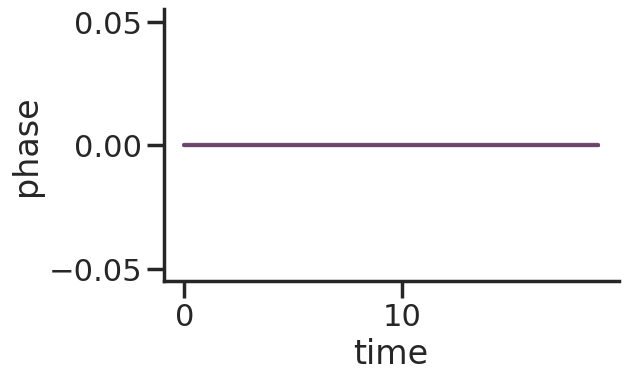

In [1]:
sns.lineplot(df_code, x='time', y='phase', hue='trial', legend=False, alpha=0.25)
plt.show()

### FF Inputs



#### Simulation



In [1]:
start = perf_counter()  

model = Network(conf_name, name, REPO_ROOT, VERBOSE=0, DEVICE='cuda', KAPPA=[0.4], REC_LAST_ONLY=1)

ini_list = np.arange(0, 125)
Ja0_list = np.linspace(10, 30, 21)
phi_list = np.linspace(0, 315, 8)

rates = model.run(ini_list, phi_list, Ja0_list)
del model 
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

print('rates', rates.shape)

# [goto error]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[448], line 12
     10 del model 
     11 end = perf_counter()
---> 12 print("Elapsed (with compilation) = {}s", self.format((end - start)))
     14 print('rates', rates.shape)

NameError: name 'self' is not defined

In [1]:
rates = rates.reshape(rates.shape[0], len(ini_list), len(phi_list), len(Ja0_list), -1)
print(rates.shape)

(1, 125, 8, 21, 1000)

#### Analysis



##### Load data



In [1]:
df = get_df_X(rates, Ja0_list, X_str='Ie')
print(df.head())

time  trial  phi    Ie  neuron      rates
0     0      0    0  10.0       0   9.067467
1     0      0    0  10.0       1  10.098180
2     0      0    0  10.0       2  10.349462
3     0      0    0  10.0       3   7.906910
4     0      0    0  10.0       4   7.308694

In [1]:
end_point = get_code_X(df, 'Ie')
print(df_code.head())

time  trial  phi    Ie        m0        m1     phase
0     0      0    0  10.0  4.745538  3.379152 -0.226161
1     0      0    0  11.0  5.059214  4.026405  0.004523
2     0      0    0  12.0  5.332169  4.750391  0.008700
3     0      0    0  13.0  5.617003  5.087596 -0.344964
4     0      0    0  14.0  5.893910  5.436195 -0.334664

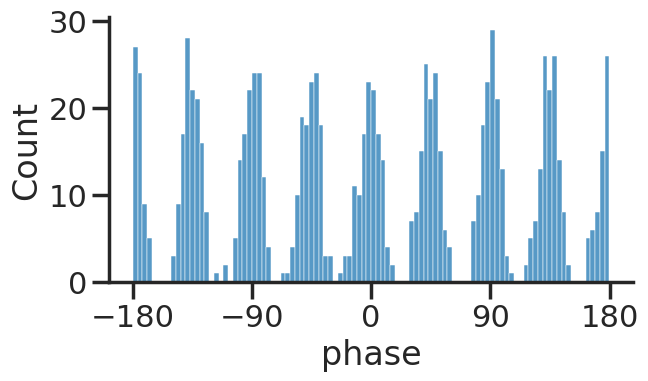

In [1]:
sns.histplot(df_code, x=df_code.phase[df_code.Ie==20]*180/np.pi, bins=100)
plt.xticks([-180, -90, 0, 90, 180])
plt.show()

In [1]:
# df = get_df_X(rates, Ja0_list, X_str='Ie')

df_smooth = df.groupby(['trial', 'phi', 'Ie'])['rates'].apply(circcvl).reset_index()

# end_point = get_code_X(df, 'Ie')

end_point['precision'] = end_point.groupby(['phi', 'Ie'], group_keys=False)['phase'].apply(get_precision) * 180 / np.pi

end_point['phase'] *= 180 / np.pi

##### Tuning Profile



In [1]:
idx_off = Ja0_list[6]
idx_on = Ja0_list[-7]
print('parameters', idx_off, idx_on)
N_E = 1000

parameters 16.0 24.0

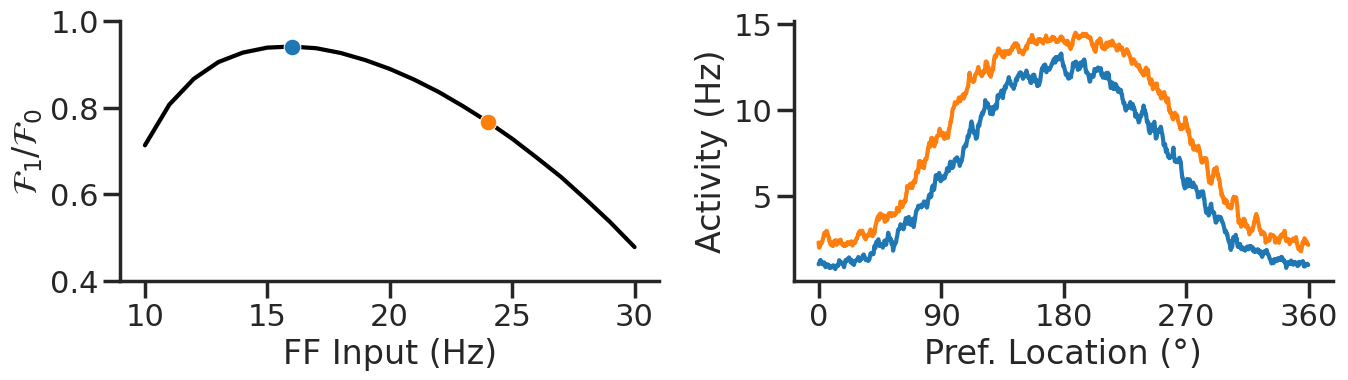

In [1]:
df_point = end_point[end_point.Ie==idx_off]
df_point_on = end_point[end_point.Ie==idx_on]

fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(end_point, x='Ie', y=end_point['m1']/end_point['m0'], ax=ax[0], legend=False, color='k')
sns.lineplot(end_point, x=idx_off, y=df_point['m1']/ df_point['m0'], ax=ax[0], legend=False, marker='o', ms=12, color=pal[0]) 
sns.lineplot(end_point, x=idx_on, y=df_point_on['m1'] / df_point_on['m0'], ax=ax[0], legend=False, marker='o', ms=12, color=pal[1])

ax[0].set_ylabel('$\mathcal{F}_1 / \mathcal{F}_0$')
ax[0].set_xlabel('FF Input (Hz)')
ax[0].set_ylim([0.4, 1])

point = df_smooth[df_smooth.Ie==idx_off].reset_index()
m0, m1, phase = decode_bump(point.rates[0])
point = np.roll(point.rates[0], int(( phase / 2.0 / np.pi - 0.5) * point.rates[0].shape[0]))

point_on = df_smooth[df_smooth.Ie==idx_on].reset_index()  
m0, m1, phase = decode_bump(point_on.rates[0])
point_on = np.roll(point_on.rates[0], int((phase / 2.0 / np.pi - 0.5) * point_on.rates[0].shape[0]))

ax[1].plot(point, color=pal[0])
ax[1].plot(point_on, color=pal[1])

ax[1].set_xticks([0, N_E/4, N_E/2, 3*N_E/4, N_E], [0, 90, 180, 270, 360])
ax[1].set_ylabel('Activity (Hz)')
ax[1].set_xlabel('Pref. Location (°)')

plt.savefig(name + '_tuning.svg', dpi=300)

plt.show()

##### Diffusion



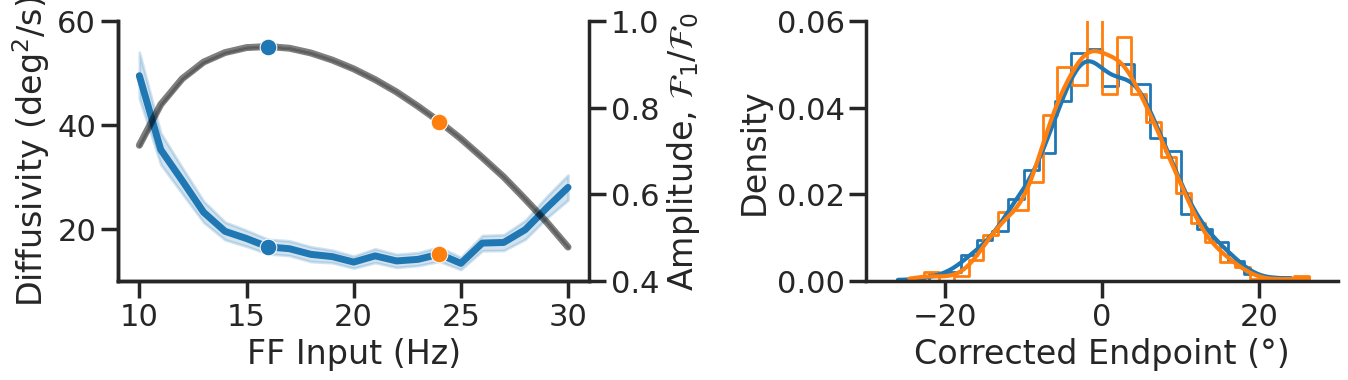

In [1]:
point = end_point[end_point.Ie==idx_off]
point_on = end_point[end_point.Ie==idx_on]

fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(end_point, x='Ie', y=end_point.precision**2 / 3.5, legend=False, ax=ax[0], lw=5)

sns.lineplot(x=idx_off, y=point['precision']**2 / 3.5, legend=False, marker='o', ax=ax[0], ms=12, color=pal[0])
sns.lineplot(x=idx_on, y=point_on['precision']**2 / 3.5, legend=False, marker='o', ax=ax[0], ms=12, color=pal[1])

ax[0].set_xlabel('FF Input (Hz)')
ax[0].set_ylabel('Diffusivity (deg$^2$/s)')
ax[0].set_ylim([10, 60])

ax1 = ax[0].twinx()
sns.lineplot(end_point, x='Ie', y=end_point['m1']/end_point['m0'], ax=ax1, legend=False, color='k', alpha=0.5, lw=5)

sns.lineplot(end_point, x=idx_off, y=point['m1']/point['m0'], legend=False, marker='o', ax=ax1, ms=12, color=pal[0])
sns.lineplot(end_point, x=idx_on, y=point_on['m1']/point_on['m0'], legend=False, marker='o', ax=ax1, ms=12, color=pal[1])

ax1.set_ylabel('Amplitude, $\mathcal{F}_1 / \mathcal{F}_0$')
# ax1.set_ylabel('Bump Amplitude')

ax1.spines['right'].set_visible(True)
ax1.set_ylim([0.4, 1])

bins = 'auto'
sns.histplot(data=point, x=point['precision'], legend=False, ax=ax[1], bins=bins, kde=True, stat='density', element='step', alpha=0,color = pal[0])
sns.histplot(data=point_on, x=point_on['precision'], legend=False, ax=ax[1], bins=bins, kde=True, stat='density', element='step', alpha=0., color=pal[1])
ax[1].set_xlabel('Corrected Endpoint (°)')
ax[1].set_ylabel('Density')
ax[1].set_xlim([-30, 30])
ax[1].set_ylim([0, 0.06])

plt.savefig(name + '_diffusion.svg', dpi=300)
plt.show()

## Distracted ODR



### Parameters



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"
conf_name = "config_bump.yml"
name = "dist_odr"

### Single



In [1]:
I1 = [0.0, 0.0]
PHI1 = 180+90
SIGMA1 = 0.25

In [1]:
start = perf_counter()
name = "odr_off"
model = Network(conf_name, name, REPO_ROOT, VERBOSE=0, DEVICE='cuda', KAPPA=[0.4], Ja0=[10], REC_LAST_ONLY=0, N_BATCH=1, VAR_FF=[30000])
rates_off = model.run()[:,0]
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))
print('rates', rates_off.shape)

Elapsed (with compilation) = 1.345799749949947s
rates (20, 1000)

In [1]:
start = perf_counter()
name = "odr_on"
model = Network(conf_name, name, REPO_ROOT, VERBOSE=0, DEVICE='cuda', KAPPA=[0.4], Ja0=[30], REC_LAST_ONLY=0, N_BATCH=1, VAR_FF=[30000])
rates_on = model.run()[:,0]
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))
print('rates', rates_on.shape)

Elapsed (with compilation) = 1.3264346839860082s
rates (20, 1000)

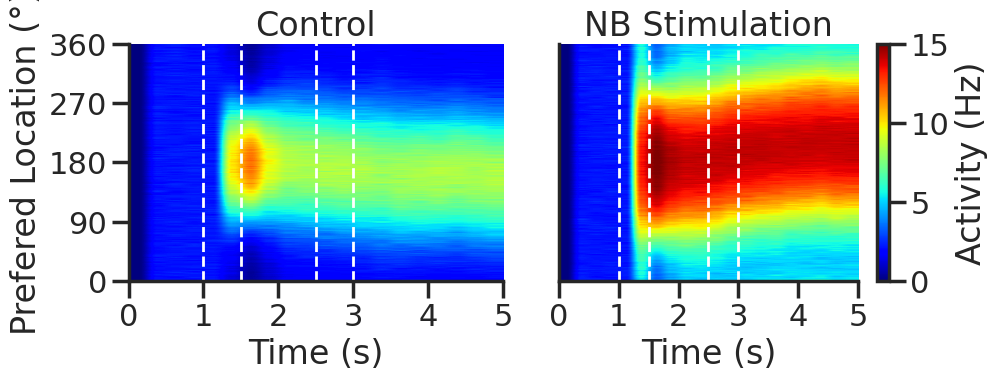

In [1]:
width = 7
golden_ratio = (5**.5 - 1) / 2
fig, ax = plt.subplots(1, 2, figsize= [1.5*width, width * golden_ratio])

times = np.linspace(0, 5, rates_off.shape[0])  
# times = np.arange(0, 5, .1)

N_E = 1000
r_min = 0
r_max = 1.5 * np.max((np.mean(rates_off), np.mean(rates_on)))
r_max=15

im = ax[0].imshow(rates_off.T, aspect='auto', cmap='jet',vmin=0, vmax=r_max, extent=[times[0], times[-1], 0, N_E])

ax[0].set_xlabel('Time (s)')
ax[0].set_xticks([0, 1, 2, 3, 4, 5])
ax[0].set_ylabel('Prefered Location (°)')
ax[0].set_yticks([0, N_E/4, N_E/2, 3*N_E/4, N_E], [0, 90, 180, 270, 360])
ax[0].set_title('Control')
ax[0].set_xlim([0, 5])

ax[0].axvline(1, 0, 1000, ls='--', color='w', lw=2)
ax[0].axvline(1.5, 0, 1000, ls='--', color='w', lw=2)
ax[0].axvline(2.5, 0, 1000, ls='--', color='w', lw=2)
ax[0].axvline(3, 0, 1000, ls='--', color='w', lw=2)

im = ax[1].imshow(rates_on.T, aspect='auto', cmap='jet',vmin=0, vmax=r_max, extent=[times[0], times[-1], 0, N_E])
ax[1].set_xlabel('Time (s)')
ax[1].set_xticks([0, 1, 2, 3, 4, 5])
ax[1].set_xlim([0, 5])

ax[1].axvline(1, 0, 1000, ls='--', color='w', lw=2)
ax[1].axvline(1.5, 0, 1000, ls='--', color='w', lw=2)
ax[1].axvline(2.5, 0, 1000, ls='--', color='w', lw=2)
ax[1].axvline(3, 0, 1000, ls='--', color='w', lw=2)

# ax[1].set_ylabel('Prefered Location (°)')
# ax[1].set_yticks([0, N_E/4, N_E/2, 3*N_E/4, N_E], [0, 90, 180, 270, 360])
ax[1].set_yticks([])
ax[1].set_title('NB Stimulation')

cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label("Activity (Hz)")
cbar.set_ticks([0, 5, 10, 15])
plt.savefig('./neurons.svg', dpi=300)
plt.show()

### Batch



In [1]:
I1 = [0.5, 0.0] # mean, variance this truncated gaussian>0
SIGMA1 = 1.0 # tuning of the distractor

In [1]:
start = perf_counter()  

ini_list = np.arange(0, 1000) # list of initializations
phi_list = np.array([-45, -90, -180, 45, 90, 180]) # list of distractors
# phi_list = np.array([45, 90, 180])
Ja0_list = np.array([10, 30]) # list of FF input strength

model = Network(conf_name, name, REPO_ROOT, VERBOSE=0, DEVICE='cuda', PHI0=0, KAPPA=[0.4], I1=I1, SIGMA1=SIGMA1)
rates_dist = model.run(ini_list, phi_list, Ja0_list, IF_DIST=1)

del model 
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

print('rates', rates_dist.shape)

Elapsed (with compilation) = 0h 0m 22s
rates (1, 12000, 1000)

In [1]:
rates_dist = rates_dist.reshape(1, len(ini_list), len(phi_list), len(Ja0_list), -1)
print(rates_dist.shape)

(1, 1000, 6, 2, 1000)

In [1]:
df = get_df_X(rates_dist, Ja0_list, X_str='Ie')

end_point = get_code_X(df, 'Ie')

end_point['precision'] = end_point.groupby(['phi', 'Ie'], group_keys=False)['phase'].apply(get_precision) * 180 / np.pi

# end_point[end_point.phase.abs()> 30 * np.pi /180] = np.nan

end_point['accuracy'] = end_point.phase * 180 / np.pi
end_point['phase'] *= 180 / np.pi

end_point.accuracy[end_point.phi==3] *= -1
end_point.accuracy[end_point.phi==4] *= -1
end_point.accuracy[end_point.phi==5] *= -1
# end_point.phi[end_point.phi==6] = 3

end_point.phi[end_point.phi==3] = 0
end_point.phi[end_point.phi==4] = 1
end_point.phi[end_point.phi==5] = 2
# end_point.phi[end_point.phi==6] = 3

# end_point[end_point.accuracy.abs()>30] = np.nan
# end_point[end_point.precision.abs()>30] = np.nan

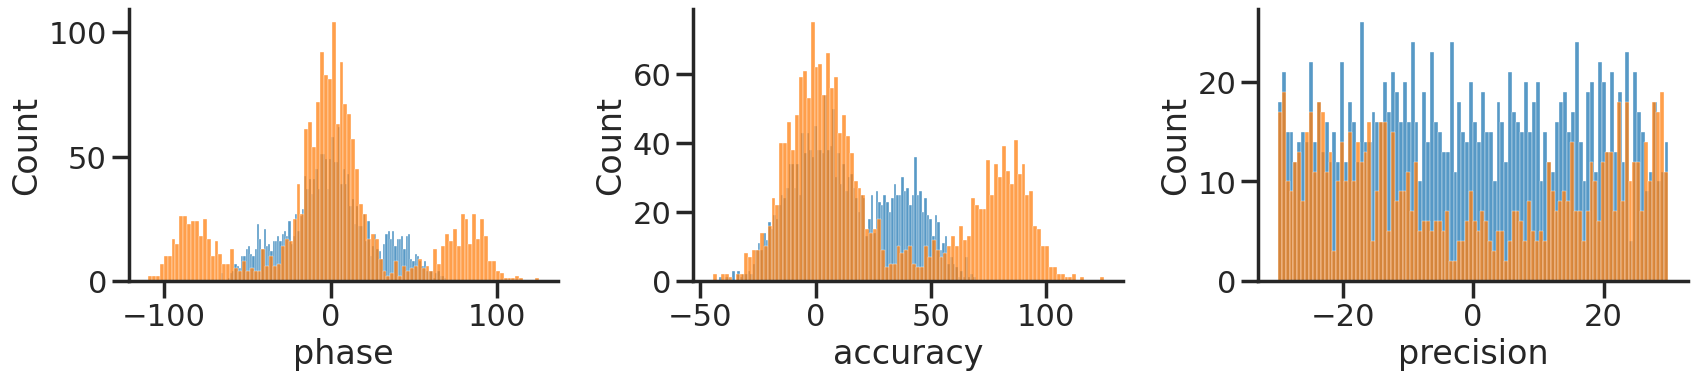

In [1]:
idx_off = Ja0_list[0]
idx_on = Ja0_list[1]

point = end_point[end_point.Ie==idx_off]
point = point[point.phi==0]

point_on = end_point[end_point.Ie==idx_off]
point_on = point_on[point_on.phi==1]

fig, ax = plt.subplots(1, 3, figsize=(2.5 * width, height))

sns.histplot(x=point['phase'], bins=100, ax=ax[0])
sns.histplot(x=point_on['phase'], bins=100, ax=ax[0])

sns.histplot(x=point['accuracy'], bins=100, ax=ax[1])
sns.histplot(x=point_on['accuracy'], bins=100, ax=ax[1])

sns.histplot(x=point['precision'], bins=100, ax=ax[2])
sns.histplot(x=point_on['precision'], bins=100, ax=ax[2])
plt.show()

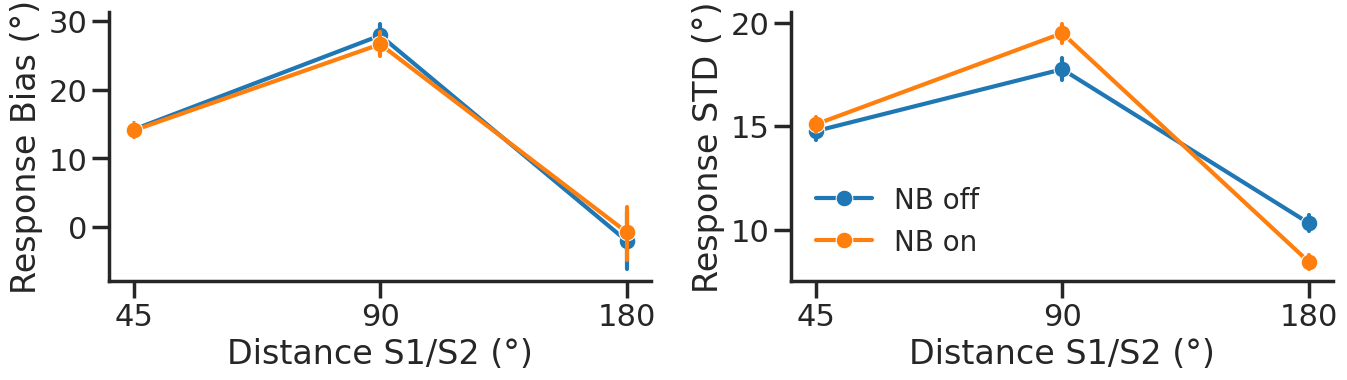

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2 * width, height))

sns.lineplot(end_point, x='phi', y=end_point['accuracy'], marker='o', ax=ax[0], err_style='bars', hue='Ie', legend=False, palette=pal, ms=12)

ax[0].set_xticks([0, 1, 2], [45, 90, 180,])
ax[0].set_xlabel('Distance S1/S2 (°)')
ax[0].set_ylabel('Response Bias (°)')

sns.lineplot(end_point, x='phi', y=end_point['precision'].abs(), marker='o', ax=ax[1], err_style='bars', hue='Ie', palette=pal, ms=12)
ax[1].set_xticks([0, 1, 2], [45, 90, 180])
ax[1].set_xlabel('Distance S1/S2 (°)')
ax[1].set_ylabel('Response STD (°)')
ax[1].legend(fontsize='small', frameon=False, labels=['NB off', 'NB on'])

plt.savefig('distance.svg', dpi=300)
plt.show()

## Quenched ODR



### Parameters



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"
conf_name = "config_bump.yml"
name = "quenched_odr"

### Time



In [1]:
ini_list = np.arange(0, 10)
phi_list = np.linspace(0, 315, 8)
print(phi_list)

[  0.  45.  90. 135. 180. 225. 270. 315.]

In [1]:
start = perf_counter()  

model = Network(conf_name, name, REPO_ROOT, VERBOSE=0, KAPPA=[0.4], SIGMA=[0.0], Ja0=[10], REC_LAST_ONLY=0)
rates = model.run(ini_list=ini_list, phi_list=phi_list)

end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

print('rates', rates.shape)

Elapsed (with compilation) = 0h 0m 1s
rates (20, 80, 1000)

In [1]:
start = perf_counter()  

model = Network(conf_name, name, REPO_ROOT, VERBOSE=0, KAPPA=[0.4], SIGMA=[0.25], Ja0=[10], REC_LAST_ONLY=0, SEED=0)
rates_dist = model.run(ini_list=ini_list, phi_list=phi_list)

end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

print('rates', rates_dist.shape)

Elapsed (with compilation) = 0h 0m 1s
rates (20, 80, 1000)

In [1]:
rates = rates.reshape(rates.shape[0], len(ini_list), len(phi_list), -1)
print(rates.shape)

rates_dist = rates_dist.reshape(rates_dist.shape[0], len(ini_list), len(phi_list), -1)
print(rates_dist.shape)

(20, 10, 8, 1000)
(20, 10, 8, 1000)

In [1]:
m0, m1, phase = decode_bump(rates)
m0, m1, phase2 = decode_bump(rates_dist)
print(phase.shape)

(20, 10, 8)

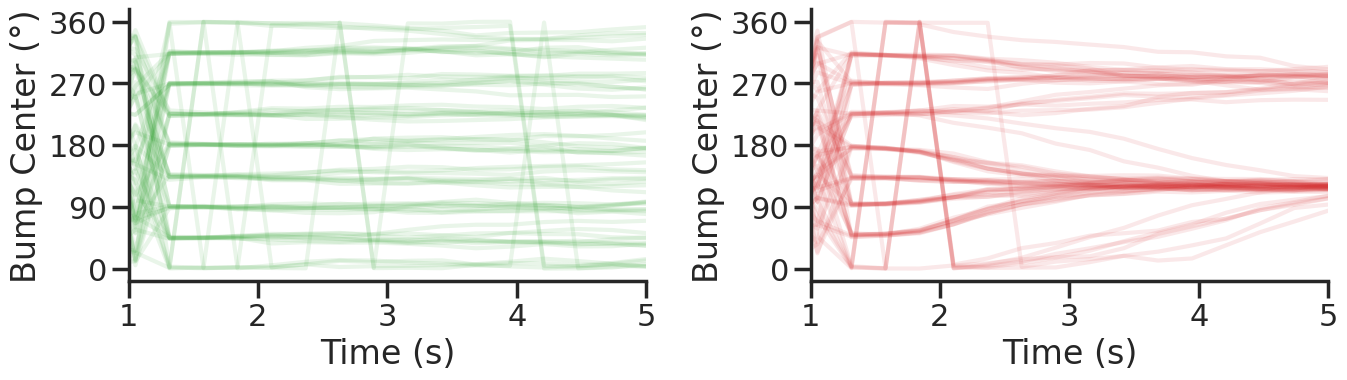

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height]) 
times = np.linspace(0, 5, phase.shape[0])  
for i in range(8):
    ax[0].plot(times, phase[:,  i, :] * 180 / np.pi + 180, alpha=.1, color=sns.color_palette("tab10")[2])

ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Bump Center (°)")
ax[0].set_yticks([0, 90, 180, 270, 360])
ax[0].set_xticks([0, 1, 2, 3, 4, 5])
ax[0].set_xlim([1, 5])

for i in range(8):
    ax[1].plot(times, phase2[:, i, :] * 180 / np.pi + 180, alpha=.1, color=sns.color_palette("tab10")[3])
ax[1].set_xlabel("Time (s)")
ax[1].set_xticks([0, 1, 2, 3, 4, 5])
ax[1].set_xlim([1, 5])
ax[1].set_ylabel("Bump Center (°)")
ax[1].set_yticks([0, 90, 180, 270, 360])

plt.savefig('phase_heter.svg', dpi=300)
plt.show()

### Heterogeneity strength



#### helpers



In [1]:
def run_X(conf_name, name, X_list, ini_list, phi_list, X_str='Jab', device = 'cuda:0', **kwargs):
    start = perf_counter()

    rates_sigma = []
    for X in X_list:
        rates = []
        for real in real_list:
            model = Network(conf_name, '%s_%s_%.2f' % (name, X_str, X),
                            REPO_ROOT, DEVICE=device, SIGMA=[X], SEED=0, **kwargs)

            rates.append(model.run(ini_list=ini_list, phi_list=phi_list))
            del model
        rates_sigma.append(rates)

    end = perf_counter()

    print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))      

    return np.array(rates_sigma)

#### parameters



In [1]:
sigma_list = np.linspace(0, 1, 11)
real_list = np.arange(0, 25)

ini_list = np.arange(0, 10)
phi_list = np.linspace(0, 315, 8)

print(sigma_list)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]

#### simulation



In [1]:
rates = run_X(conf_name, name, sigma_list, ini_list, phi_list, X_str='sigma', device='cuda')
print(rates.shape)

Elapsed (with compilation) = 0h 6m 28s
(11, 25, 1, 80, 1000)

In [1]:
rates = np.moveaxis(rates, 0, -2)
rates = rates[:,0]
print(rates.shape)

(100, 21, 1, 1000)

In [1]:
rates = rates.reshape(rates.shape[0], len(ini_list), len(phi_list), len(sigma_list), -1)
print(rates.shape)

# [goto error]
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[746], line 1
----> 1 rates = rates.reshape(rates.shape[0], len(ini_list), len(phi_list), len(sigma_list), -1)
      2 print(rates.shape)

ValueError: cannot reshape array of size 2100000 into shape (100,100,8,11,newaxis)

#### Analysis



###### Load data



In [1]:
df = get_df_X(rates, sigma_list, X_str='sigma')
end_point = get_code_X(df, 'sigma')
df_smooth = df.groupby(['time', 'trial', 'phi', 'sigma'])['rates'].apply(circcvl).reset_index()

end_point['precision'] = end_point.groupby(['time', 'phi', 'sigma'], group_keys=False)['phase'].apply(get_precision) * 180 / np.pi

###### Tuning Profile



In [1]:
idx_off = sigma_list[1]
idx_on = sigma_list[5]
print('parameters', idx_off, idx_on)
N_E = 1000

parameters 0.1 0.5

In [1]:
df_point = end_point[end_point.sigma==idx_off]
df_point_on = end_point[end_point.sigma==idx_on]
print(df_point_on.head())

time  trial  phi  sigma        m0        m1     phase  precision
5      0      0    0    0.5  5.823681  3.369071  1.956437   2.293273
16     0      0    1    0.5  5.824378  3.160698  1.816514  -0.249574
27     0      0    2    0.5  5.840415  3.123927  1.691448 -11.021806
38     0      0    3    0.5  5.866175  3.077265  1.844028  -1.311344
49     0      0    4    0.5  5.880684  3.336417  1.883580   0.517090

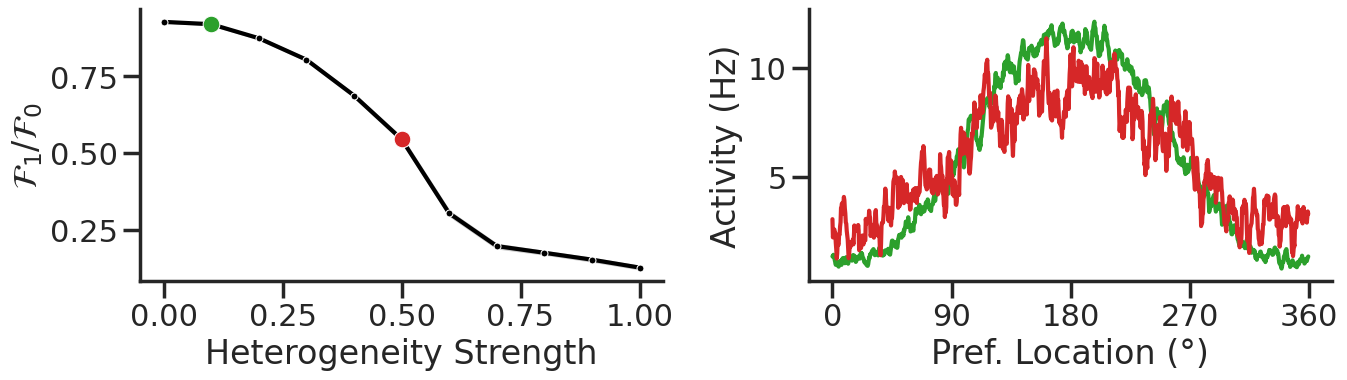

In [1]:
df_point = end_point[end_point.sigma==idx_off]
df_point_on = end_point[end_point.sigma==idx_on]

fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(end_point, x='sigma', y=end_point['m1']/end_point['m0'], ax=ax[0], legend=False, marker='o', color='k')
sns.lineplot(end_point, x=idx_off, y=df_point['m1']/ df_point['m0'], ax=ax[0], legend=False, marker='o', ms=12, color=pal[2]) 
sns.lineplot(end_point, x=idx_on, y=df_point_on['m1'] / df_point_on['m0'], ax=ax[0], legend=False, marker='o', ms=12, color=pal[3])

ax[0].set_ylabel('$\mathcal{F}_1 / \mathcal{F}_0$')
ax[0].set_xlabel('Heterogeneity Strength')
# ax[0].set_ylim([0.4, 1])

point = df_smooth[df_smooth.sigma==idx_off].reset_index()
m0, m1, phase = decode_bump(point.rates[0])
point = np.roll(point.rates[0], int(( phase / 2.0 / np.pi - 0.5) * point.rates[0].shape[0]))

point_on = df_smooth[df_smooth.sigma==idx_on].reset_index()  
m0, m1, phase = decode_bump(point_on.rates[0])
point_on = np.roll(point_on.rates[0], int((phase / 2.0 / np.pi - 0.5) * point_on.rates[0].shape[0]))

ax[1].plot(point, color=pal[2])
ax[1].plot(point_on, color=pal[3])

ax[1].set_xticks([0, N_E/4, N_E/2, 3*N_E/4, N_E], [0, 90, 180, 270, 360])
ax[1].set_ylabel('Activity (Hz)')
ax[1].set_xlabel('Pref. Location (°)')

plt.savefig(name + '_tuning_sigma.svg', dpi=300)

plt.show()

###### Diffusion



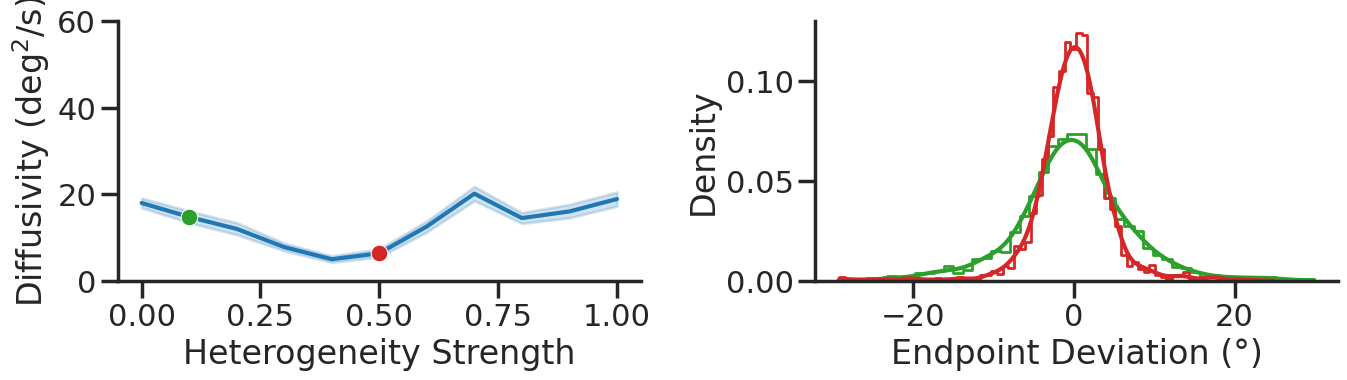

In [1]:
point = end_point[end_point.sigma==idx_off]
point_on = end_point[end_point.sigma==idx_on]

fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(end_point, x='sigma', y=end_point.precision**2 / 3.5, legend=False, ax=ax[0])

sns.lineplot(x=idx_off, y=point['precision']**2 / 3.5, legend=False, marker='o', ax=ax[0], ms=12, color=pal[2])
sns.lineplot(x=idx_on, y=point_on['precision']**2 / 3.5, legend=False, marker='o', ax=ax[0], ms=12, color=pal[3])

ax[0].set_xlabel('Heterogeneity Strength')
ax[0].set_ylabel('Diffusivity (deg$^2$/s)')
ax[0].set_ylim([0, 60])
#  ax1 = ax[0].twinx()
# sns.lineplot(end_point, x='sigma', y=end_point['m1']/end_point['m0'], ax=ax1, legend=False, color='k', alpha=0.25)

# sns.lineplot(end_point, x=idx_off, y=point['m1']/point['m0'], legend=False, marker='o', ax=ax1, ms=12, color=pal[0])
# sns.lineplot(end_point, x=idx_on, y=point_on['m1']/point_on['m0'], legend=False, marker='o', ax=ax1, ms=12, color=pal[1])

# ax1.set_ylabel('$\mathcal{F}_1 / \mathcal{F}_0$')
# ax1.spines['right'].set_visible(True)
# ax1.set_ylim([0.4, 1])

# point = df_smooth[df_smooth.sigma==idx_off].reset_index()
# m0, m1, phase = decode_bump(point.rates[4])
# point = np.roll(point.rates[4], int(( phase / 2.0 / np.pi - 0.5) * point.rates[4].shape[0]))

# point_on = df_smooth[df_smooth.sigma==idx_on].reset_index()  
# m0, m1, phase = decode_bump(point_on.rates[4])
# point_on = np.roll(point_on.rates[4], int((phase / 2.0 / np.pi - 0.5) * point_on.rates[4].shape[0]))

# ax[1].plot(point, color=pal[0])
# ax[1].plot(point_on, color=pal[1])

# ax[1].set_xticks([0, N_E/4, N_E/2, 3*N_E/4, N_E], [0, 90, 180, 270, 360])
# ax[1].set_ylabel('Firing Rate (Hz)')
# ax[1].set_xlabel('Pref. Location (°)')

# point = end_point[end_point.sigma==idx_off]
# point_on = end_point[end_point.sigma==idx_on]

bins = 'auto'
sns.histplot(data=point, x=point['precision'], legend=False, ax=ax[1], bins=bins, kde=True, stat='density', element='step', alpha=0, color = pal[2])
sns.histplot(data=point_on, x=point_on['precision'], legend=False, ax=ax[1], bins=bins, kde=True, stat='density', element='step', alpha=0., color=pal[3])
ax[1].set_xlabel('Endpoint Deviation (°)')
ax[1].set_ylabel('Density')
# ax[1].set_xlim([-30, 30])

plt.savefig(name + '_diffusion_sigma.svg', dpi=300)
plt.show()

### FF Inputs



#### Parameters



In [1]:
ini_list = np.arange(0, 100)
Ja0_list = np.linspace(10, 30, 21)
phi_list = np.linspace(0, 315, 8)

#### Simulations



In [1]:
start = perf_counter()  

model = Network(conf_name, name, REPO_ROOT, VERBOSE=0, DEVICE='cuda', KAPPA=[0.4], SIGMA=[0.25], SEED=0)
rates = model.run(ini_list, phi_list, Ja0_list)

end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

print('rates', rates.shape)

Elapsed (with compilation) = 0h 0m 45s
rates (1, 16800, 1000)

In [1]:
rates = rates.reshape(1, len(ini_list), len(phi_list), len(Ja0_list), -1)
print(rates.shape)

(1, 100, 8, 21, 1000)

#### Analysis



##### Load data



In [1]:
df = get_df_X(rates, Ja0_list, X_str='Ie')
end_point = get_code_X(df, 'Ie')
df_smooth = df.groupby(['trial', 'phi', 'Ie'])['rates'].apply(circcvl).reset_index()
end_point['accuracy'] = (end_point.phase - end_point['phi'] / 180 * np.pi) 
end_point['precision'] = end_point.groupby(['phi', 'Ie'], group_keys=False)['phase'].apply(get_precision) * 180 / np.pi

##### Tuning Profile



In [1]:
idx_off = Ja0_list[0]
idx_on = Ja0_list[-1]
print('parameters', idx_off, idx_on)
N_E = 1000

parameters 10.0 30.0

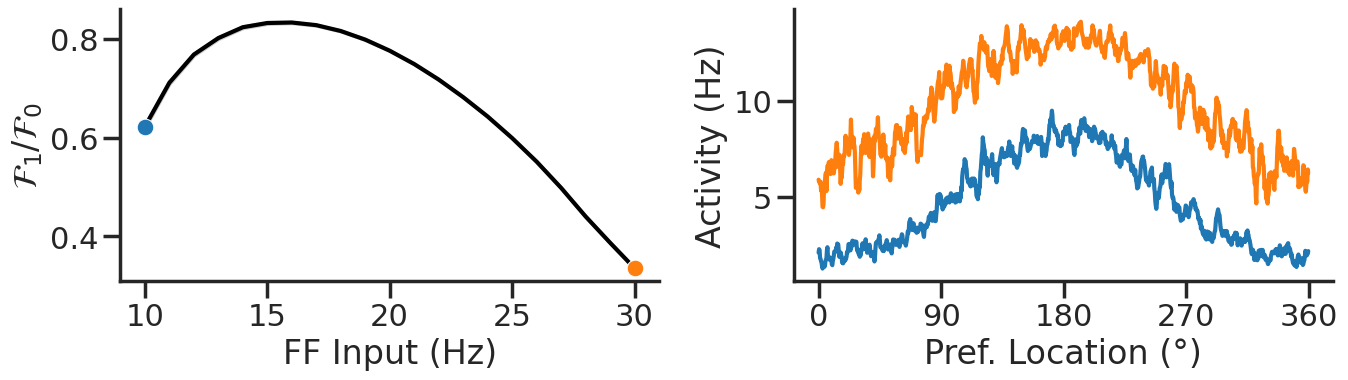

In [1]:
df_point = end_point[end_point.Ie==idx_off]
df_point_on = end_point[end_point.Ie==idx_on]

fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(end_point, x='Ie', y=end_point['m1']/end_point['m0'], ax=ax[0], legend=False, color='k')
sns.lineplot(end_point, x=idx_off, y=df_point['m1']/ df_point['m0'], ax=ax[0], legend=False, marker='o', ms=12, color=pal[0]) 
sns.lineplot(end_point, x=idx_on, y=df_point_on['m1'] / df_point_on['m0'], ax=ax[0], legend=False, marker='o', ms=12, color=pal[1])

ax[0].set_ylabel('$\mathcal{F}_1 / \mathcal{F}_0$')
ax[0].set_xlabel('FF Input (Hz)')
# ax[0].set_ylim([0.4, 1])

point = df_smooth[df_smooth.Ie==idx_off].reset_index()
m0, m1, phase = decode_bump(point.rates[0])
point = np.roll(point.rates[0], int(( phase / 2.0 / np.pi - 0.5) * point.rates[0].shape[0]))

point_on = df_smooth[df_smooth.Ie==idx_on].reset_index()  
m0, m1, phase = decode_bump(point_on.rates[0])
point_on = np.roll(point_on.rates[0], int((phase / 2.0 / np.pi - 0.5) * point_on.rates[0].shape[0]))

ax[1].plot(point, color=pal[0])
ax[1].plot(point_on, color=pal[1])

ax[1].set_xticks([0, N_E/4, N_E/2, 3*N_E/4, N_E], [0, 90, 180, 270, 360])
ax[1].set_ylabel('Activity (Hz)')
ax[1].set_xlabel('Pref. Location (°)')

plt.savefig(name + '_tuning.svg', dpi=300)

plt.show()

##### Diffusion



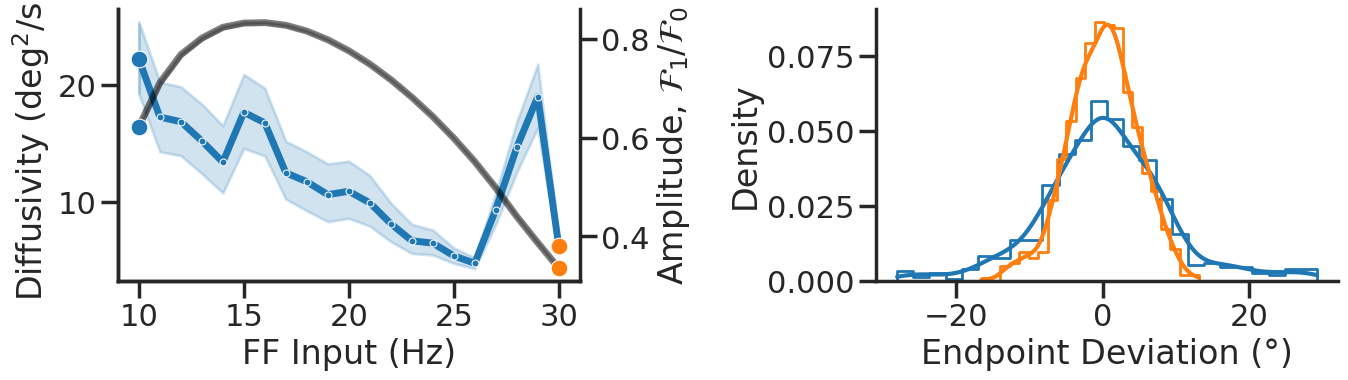

In [1]:
point = end_point[end_point.Ie==idx_off]
point_on = end_point[end_point.Ie==idx_on]

fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(end_point, x='Ie', y=end_point.precision**2 / 3.5, legend=False, marker='o', ax=ax[0], lw=5)

sns.lineplot(x=idx_off, y=point['precision']**2 / 3.5, legend=False, marker='o', ax=ax[0], ms=12, color=pal[0])
sns.lineplot(x=idx_on, y=point_on['precision']**2 / 3.5, legend=False, marker='o', ax=ax[0], ms=12, color=pal[1])

ax[0].set_xlabel('FF Input (Hz)')
ax[0].set_ylabel('Diffusivity (deg$^2$/s)')
# ax[0].set_ylim([0, 10])

ax1 = ax[0].twinx()
sns.lineplot(end_point, x='Ie', y=end_point['m1']/end_point['m0'], ax=ax1, legend=False, color='k', alpha=0.5, lw=5)

sns.lineplot(end_point, x=idx_off, y=point['m1']/point['m0'], legend=False, marker='o', ax=ax1, ms=12, color=pal[0])
sns.lineplot(end_point, x=idx_on, y=point_on['m1']/point_on['m0'], legend=False, marker='o', ax=ax1, ms=12, color=pal[1])

ax1.set_ylabel('Amplitude, $\mathcal{F}_1 / \mathcal{F}_0$')
ax1.spines['right'].set_visible(True)
# ax1.set_ylim([0.4, 1])

bins = 'auto'
sns.histplot(data=point, x=point['precision'], legend=False, ax=ax[1], bins=bins, kde=True, stat='density', element='step', alpha=0,color = pal[0])
sns.histplot(data=point_on, x=point_on['precision'], legend=False, ax=ax[1], bins=bins, kde=True, stat='density', element='step', alpha=0., color=pal[1])
ax[1].set_xlabel('Endpoint Deviation (°)')
ax[1].set_ylabel('Density')
# ax[1].set_xlim([-30, 30])

plt.savefig(name + '_diffusion.svg', dpi=300)
plt.show()